In [2]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import sys
sys.path.append('/remote/tychodata/ftairli/work/Projects/MuonSignal/Models')

In [3]:
plt.rcParams['figure.figsize'] = [15, 12]

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using Device:', device)

Main  = torch.load('../Data/NormData/Main_test.pt')
Aux   = torch.load('../Data/NormData/Aux_test.pt')
Truth = torch.load('../Data/NormData/Truth_test.pt')
EventMyId = torch.load('../Data/NormData/EventMyId_test.pt')

Aux = Aux.unsqueeze(2)
Truth = Truth.unsqueeze(2)

Main = Main.transpose(1,2)

# Truth = Truth.sum(dim=1).unsqueeze(1)
print(Main.shape, Aux.shape, Truth.shape)

Using Device: cuda
torch.Size([169157, 120, 3]) torch.Size([169157, 4, 1]) torch.Size([169157, 120, 1])


In [5]:
print(Main.shape)
print(Main.sum(dim=1).shape)
newMain = Main / Main.sum(dim=1).unsqueeze(1)
print(newMain.shape)

torch.Size([169157, 120, 3])
torch.Size([169157, 3])
torch.Size([169157, 120, 3])


In [6]:
Names = ['Model_3_Baseline','Model_3_BaselineAll','Model_3_logEOnly','Model_3_XmaxOnly','Model_3_CosZenOnly','Model_3_CoreDistOnly']
models = {}
trackers = {}
for name in Names:
    models[name] = torch.load('../Models/'+name+'.pt')
    trackers[name] = torch.load('../Models/'+name+'_Tracker.pt')

UnnormaliseY = models['Model_3_Baseline'].UnnormaliseY
Truth = UnnormaliseY(Truth).sum(dim=1)/UnnormaliseY(Main).mean(dim=2).sum(dim=1).unsqueeze(1)



In [7]:
print(Truth.shape)

torch.Size([169157, 1])


In [8]:
for t in trackers:
    print(t)

Model_3_Baseline
Model_3_BaselineAll
Model_3_logEOnly
Model_3_XmaxOnly
Model_3_CosZenOnly
Model_3_CoreDistOnly


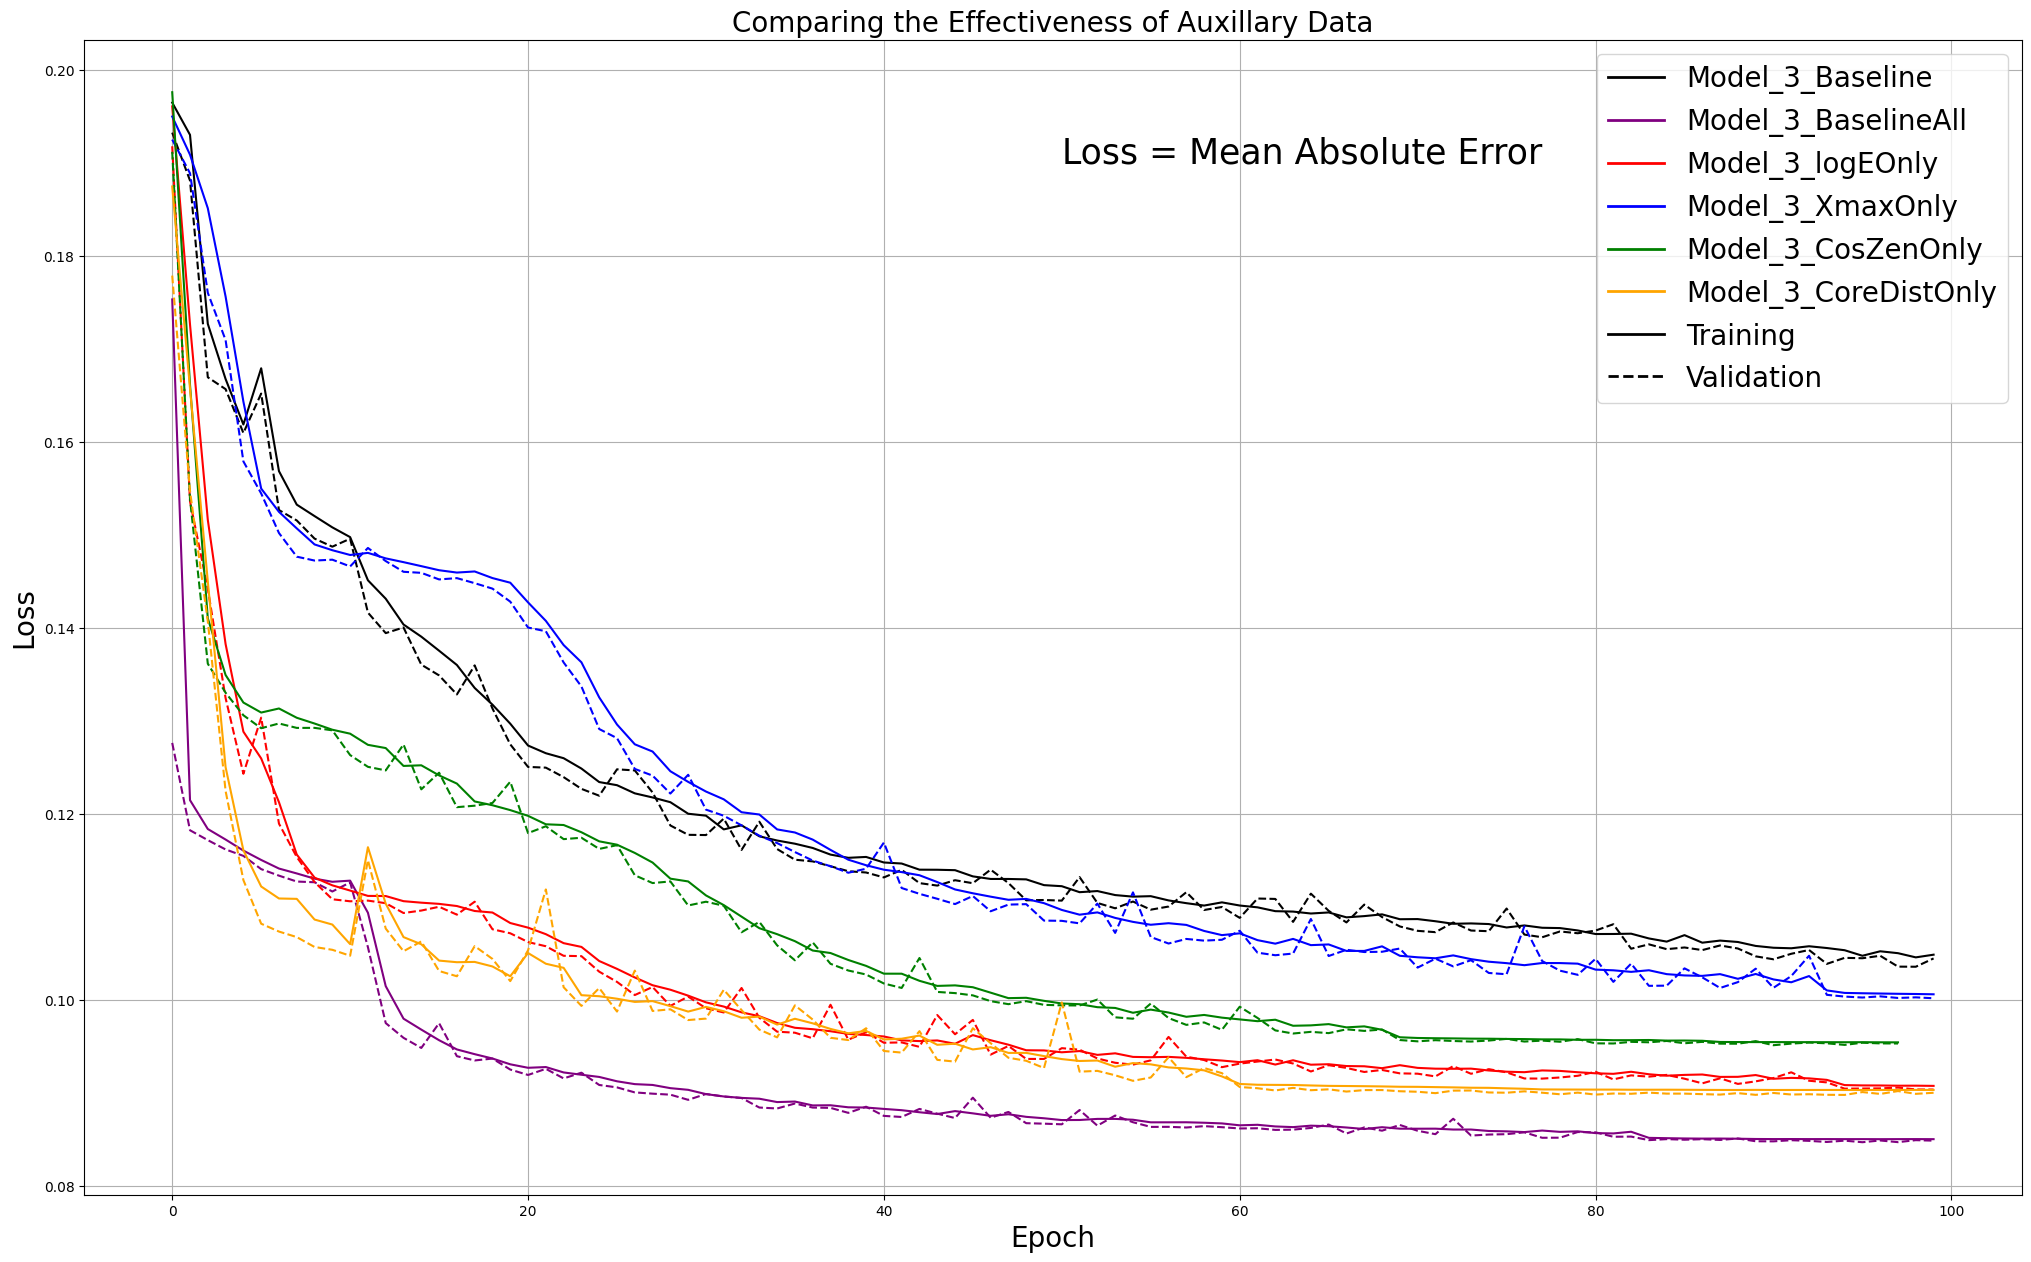

In [9]:
plt.figure(figsize=(25,15))
colors = {'Model_3_Baseline':'black','Model_3_BaselineAll':'purple','Model_3_logEOnly':'red','Model_3_XmaxOnly':'blue','Model_3_CosZenOnly':'green','Model_3_CoreDistOnly':'orange'}
custom_lines = []
custom_labels = []
for i,name in enumerate(Names):
    plt.plot(trackers[name].EpochLoss, label=name,linestyle = '-',color = colors[name])
    plt.plot(trackers[name].EpochValLoss, label=name,linestyle = '--',color = colors[name])
    custom_lines.append(Line2D([0], [0], color=colors[name], lw=2))
    custom_labels.append(name)
    
custom_lines.append(Line2D([0], [0], color='black', lw=2))
custom_lines.append(Line2D([0], [0], color='black', linestyle='dashed', lw=2))

custom_labels.append('Training')
custom_labels.append('Validation')

plt.legend(custom_lines,custom_labels,fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.title('Comparing the Effectiveness of Auxillary Data',fontsize=20)
plt.text(50,0.19,'Loss = Mean Absolute Error',fontsize=25)
plt.grid()
plt.show()

In [10]:
BatchSize      = 100
from Model_1_0 import MyDataset
from torch.utils.data import DataLoader

test_dataset = MyDataset(Main,Aux,Truth)
dataloader_test = DataLoader(test_dataset,batch_size=BatchSize)



models_pred = {}
models_truth = {}

for name,model in zip(models.keys(),models.values()):
    model.eval()
    model.to(device)

    pred  = np.zeros(shape = (Main.shape[0],1))
    truth = np.zeros(shape = (Main.shape[0],1))

    filled = 0
    BatchN = 0
    print(f'Beginging to compute model {name}')
    with torch.no_grad():
        for batch_Main,batch_Aux,batch_Truth in dataloader_test:

            print(f'\rBatch {BatchN} of {len(dataloader_test)}',end='')

            batch_Main = batch_Main.to(device)
            batch_Aux = batch_Aux.to(device)
            Current_BatchSize = batch_Main.shape[0]
            
            Results = model(batch_Main,batch_Aux)
            Truths  = batch_Truth
            
            pred[filled: filled+Current_BatchSize] = Results.cpu().numpy()
            truth[filled: filled+Current_BatchSize] = Truths.cpu().numpy()
            
            filled += Current_BatchSize
            BatchN += 1
    models_pred[name] = pred
    models_truth[name] = truth
    print()

# del model

Beginging to compute model Model_3_Baseline
Batch 1691 of 1692
Beginging to compute model Model_3_BaselineAll
Batch 1691 of 1692
Beginging to compute model Model_3_logEOnly
Batch 1691 of 1692
Beginging to compute model Model_3_XmaxOnly
Batch 1691 of 1692
Beginging to compute model Model_3_CosZenOnly
Batch 1691 of 1692
Beginging to compute model Model_3_CoreDistOnly
Batch 1691 of 1692


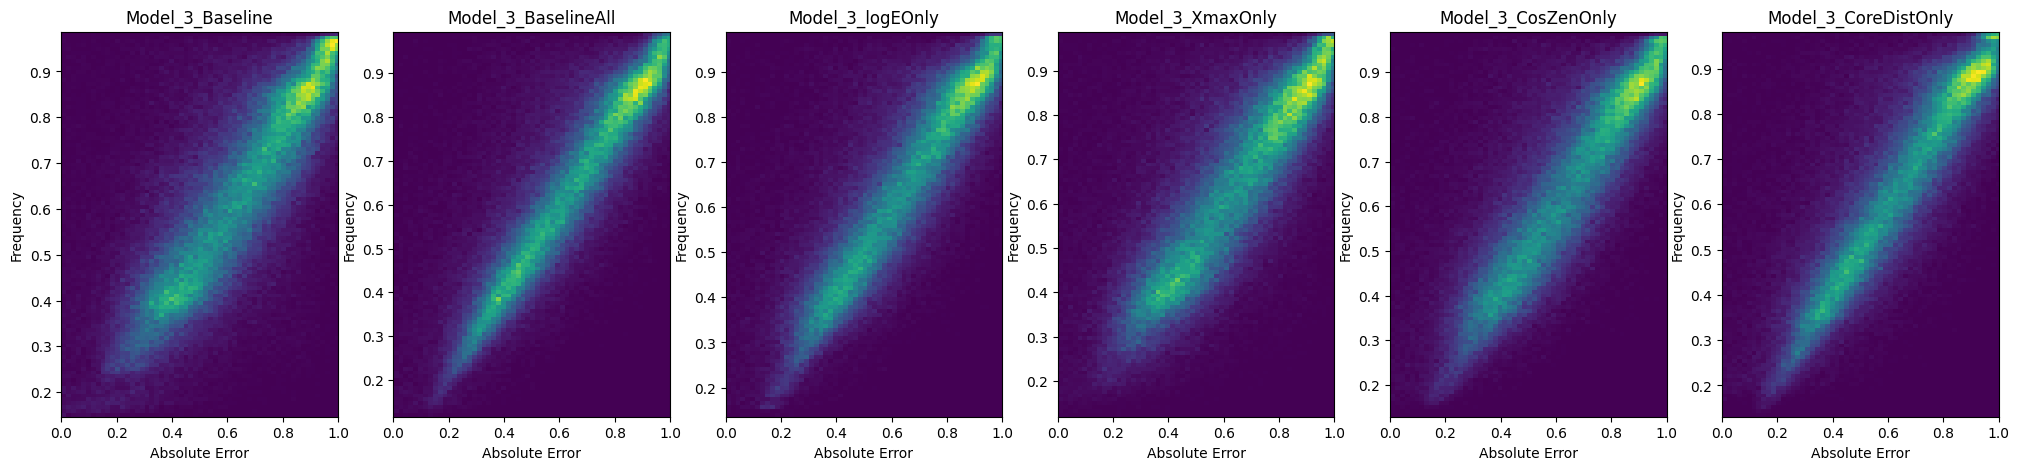

In [12]:
AbsError = {}
for name in models_pred.keys():
    AbsError[name] = np.abs(models_pred[name]-models_truth[name])

fig,ax = plt.subplots(1,6,figsize=(25,5))
for i,(name,abserror) in enumerate(zip(AbsError.keys(),AbsError.values())):
    # ax[i].hist(abserror,bins=100)
    # ax[i].scatter(models_truth[name],models_pred[name],marker = '.',s = 0.5)
    ax[i].hist2d(models_truth[name].flatten(),models_pred[name].flatten(),bins=100)
    ax[i].set_title(name)
    # reso = np.percentile(abserror,68)
    # ax[i].axvline(reso,color='red')
    # ax[i].text(0.5,0.9,f'$\sigma$ = {reso:.3f}',transform=ax[i].transAxes)
    ax[i].set_xlabel('Absolute Error')
    ax[i].set_ylabel('Frequency')
    # ax[i].set_yscale('log')
    ax[i].set_xlim(0,1)
plt.show()


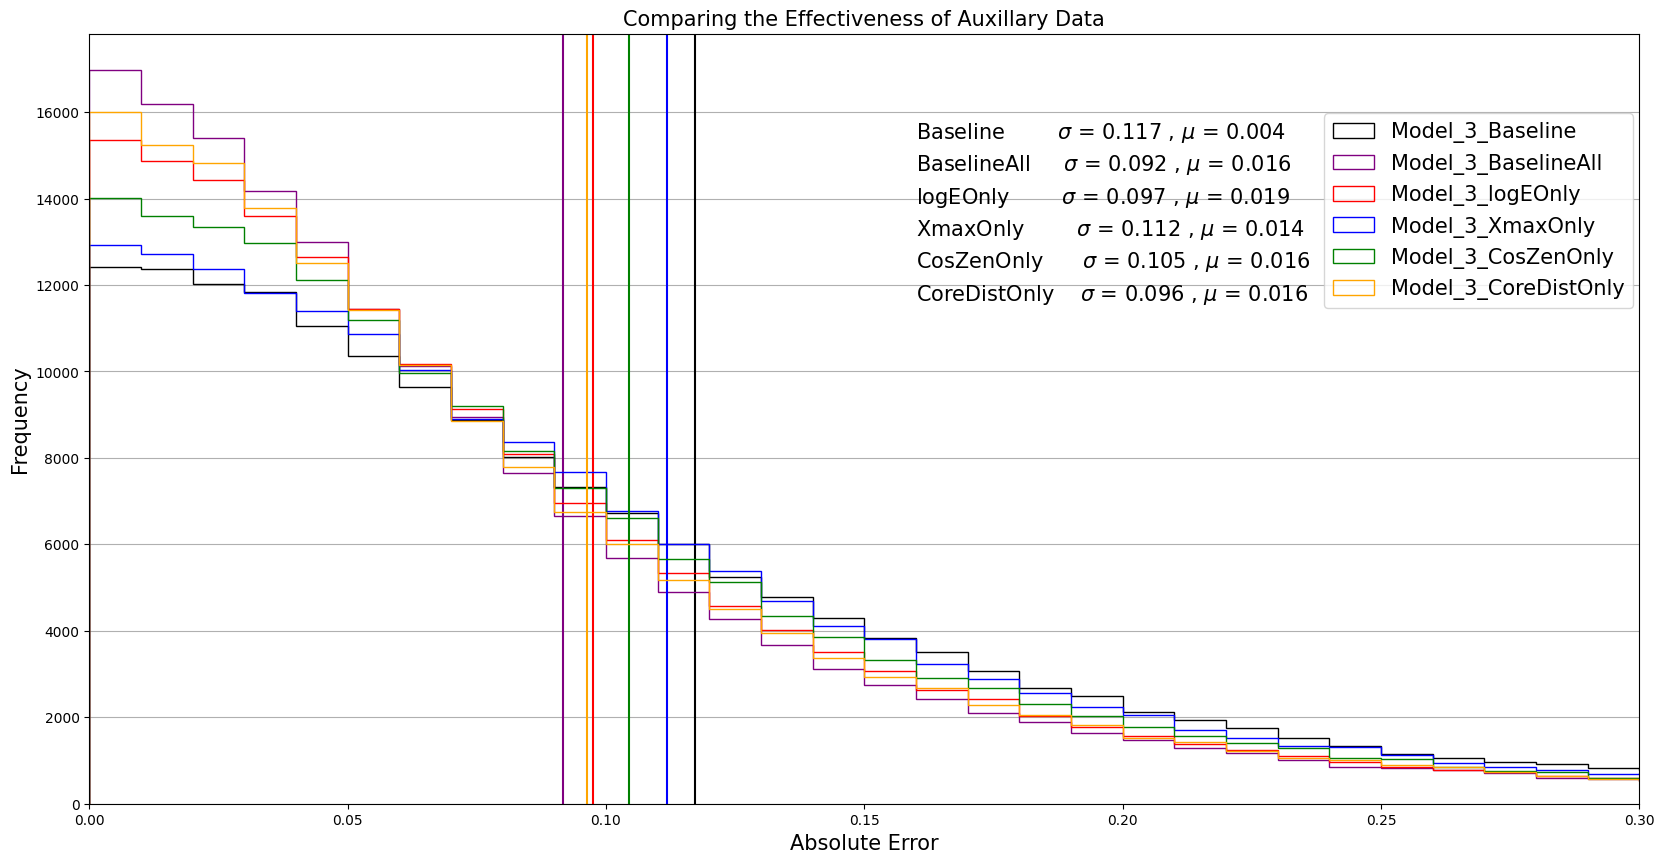

In [71]:
AbsError = {}
means    = {}
for name in models_pred.keys():
    AbsError[name] = models_pred[name]-models_truth[name]
    means[name]    = np.mean(AbsError[name])
    AbsError[name] = np.abs(AbsError[name])
h =15400
plt.figure(figsize=(20,10))
for i,(name,abserror) in enumerate(zip(AbsError.keys(),AbsError.values())):
    plt.hist(abserror,bins=100,range=(0,1),histtype='step',label=name,color=colors[name])
    
    reso = np.percentile(abserror,68)
    mean = means[name]
    plt.axvline(reso,color=colors[name])
    plt.text(0.16,h,f'{name[8:].ljust(15)} $\sigma$ = {reso:.3f} , $\mu$ = {mean:.3f}',fontsize=15)
    h -=750
plt.xlim(0,0.3)
# plt.yscale('log')
plt.legend(fontsize = 15,loc = 'upper left',bbox_to_anchor = [0.79,0.91])
plt.grid(axis = 'y')
plt.xlabel('Absolute Error',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Comparing the Effectiveness of Auxillary Data',fontsize=15)
plt.show()


In [ ]:
$